In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve



In [8]:
# Load the data
data = pd.read_csv('../../data/clean/energy/clean_energy_close.csv')


In [9]:
# check numbers of rows and columns
print(data.shape)

(1259, 47)


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def find_middle_benchmarks(csv_file, num_benchmarks=3, by_metric='return'):
    """
    Find the middle-performing stocks to use as benchmarks.
    
    Parameters:
    csv_file (str): Path to the CSV file with stock data
    num_benchmarks (int): Number of middle performers to return as benchmarks
    by_metric (str): Metric to use for finding middle performers ('return' or 'sharpe')
    
    Returns:
    dict: Dictionary with benchmark information including tickers and metrics
    """
    # Load the data
    df = pd.read_csv(csv_file)
    
    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Set Date as index for calculations
    df_indexed = df.set_index('Date')
    
    # Calculate total return for each stock
    start_prices = df_indexed.iloc[0]
    end_prices = df_indexed.iloc[-1]
    returns = ((end_prices - start_prices) / start_prices) * 100
    
    # Calculate daily returns and volatility for Sharpe ratio
    daily_returns = df_indexed.pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252)  # Annualized
    
    # Calculate Sharpe ratios (assuming 2% risk-free rate)
    risk_free_rate = 0.02
    daily_rf_rate = risk_free_rate / 252
    excess_returns = daily_returns - daily_rf_rate
    sharpe_ratios = (excess_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))
    
    # Calculate average metrics
    avg_return = returns.mean()
    avg_sharpe = sharpe_ratios.mean()
    
    if by_metric.lower() == 'return':
        # Find stocks closest to the average return
        metric_diff = abs(returns - avg_return)
        middle_tickers = metric_diff.nsmallest(num_benchmarks).index.tolist()
        metric_name = "return"
        metric_values = returns
        avg_metric = avg_return
    elif by_metric.lower() == 'sharpe':
        # Find stocks closest to the average Sharpe ratio
        metric_diff = abs(sharpe_ratios - avg_sharpe)
        middle_tickers = metric_diff.nsmallest(num_benchmarks).index.tolist()
        metric_name = "Sharpe ratio"
        metric_values = sharpe_ratios
        avg_metric = avg_sharpe
    else:
        raise ValueError("by_metric must be either 'return' or 'sharpe'")
    
    print(f"Average {metric_name} across all stocks: {avg_metric:.2f}")
    print(f"Middle benchmark tickers (by {metric_name}): {middle_tickers}")
    print(f"Their {metric_name}s:")
    for ticker in middle_tickers:
        print(f"  {ticker}: {metric_values[ticker]:.2f}")
    
    return {
        'tickers': middle_tickers,
        'avg_return': avg_return,
        'avg_sharpe': avg_sharpe,
        'metric': by_metric,
        'returns': returns[middle_tickers],
        'sharpe_ratios': sharpe_ratios[middle_tickers]
    }

def analyze_winners_losers(csv_file, benchmark_tickers, top_n=5, by_metric='return'):
    """
    Compare top winners and losers against benchmark tickers.
    
    Parameters:
    csv_file (str): Path to the CSV file with stock data
    benchmark_tickers (list): List of ticker symbols to use as benchmarks
    top_n (int): Number of top/bottom performers to analyze
    by_metric (str): Metric to use for finding winners/losers ('return' or 'sharpe')
    
    Returns:
    dict: Analysis results including winners, losers, and benchmarks
    """
    # Load the data
    df = pd.read_csv(csv_file)
    
    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Set Date as index
    df.set_index('Date', inplace=True)
    
    # Calculate returns
    start_prices = df.iloc[0]
    end_prices = df.iloc[-1]
    returns = ((end_prices - start_prices) / start_prices) * 100
    
    # Calculate daily returns and volatility
    daily_returns = df.pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252)  # Annualized
    
    # Calculate Sharpe ratios (assuming 2% risk-free rate)
    risk_free_rate = 0.02
    daily_rf_rate = risk_free_rate / 252
    excess_returns = daily_returns - daily_rf_rate
    sharpe_ratios = (excess_returns.mean() * 252) / (daily_returns.std() * np.sqrt(252))
    
    # Calculate benchmark metrics
    benchmark_returns = returns[benchmark_tickers].mean()
    benchmark_volatility = volatility[benchmark_tickers].mean()
    benchmark_sharpe = sharpe_ratios[benchmark_tickers].mean()
    
    # Find top winners and losers based on specified metric
    if by_metric.lower() == 'return':
        winners = returns.nlargest(top_n)
        losers = returns.nsmallest(top_n)
        metric_name = 'return'
    elif by_metric.lower() == 'sharpe':
        winners = sharpe_ratios.nlargest(top_n)
        losers = sharpe_ratios.nsmallest(top_n)
        metric_name = 'Sharpe ratio'
    else:
        raise ValueError("by_metric must be either 'return' or 'sharpe'")
    
    # Normalize all stocks to start at 100 for visualization
    first_day = df.iloc[0]
    normalized_df = df.div(first_day) * 100
    
    # Create a combined benchmark series (average of benchmark tickers)
    benchmark_series = normalized_df[benchmark_tickers].mean(axis=1)
    
    # Print results
    print("\n=== BENCHMARK METRICS ===")
    print(f"Benchmark tickers: {benchmark_tickers}")
    print(f"Benchmark return: {benchmark_returns:.2f}%")
    print(f"Benchmark volatility: {benchmark_volatility:.2f}")
    print(f"Benchmark Sharpe ratio: {benchmark_sharpe:.2f}")
    print()
    
    print(f"=== TOP WINNERS (BY {by_metric.upper()}) ===")
    for ticker, value in winners.items():
        if by_metric.lower() == 'return':
            metric_value = value
            metric_diff = value - benchmark_returns
            metric_unit = '%'
        else:  # sharpe
            metric_value = value
            metric_diff = value - benchmark_sharpe
            metric_unit = ''
            
        print(f"{ticker}: {metric_value:.2f}{metric_unit} (vs benchmark: {metric_diff:+.2f})")
        print(f"  Return: {returns[ticker]:.2f}% (vs benchmark: {returns[ticker] - benchmark_returns:+.2f}%)")
        print(f"  Volatility: {volatility[ticker]:.2f} (vs benchmark: {volatility[ticker] - benchmark_volatility:+.2f})")
        print(f"  Sharpe: {sharpe_ratios[ticker]:.2f} (vs benchmark: {sharpe_ratios[ticker] - benchmark_sharpe:+.2f})")
    print()
    
    print(f"=== TOP LOSERS (BY {by_metric.upper()}) ===")
    for ticker, value in losers.items():
        if by_metric.lower() == 'return':
            metric_value = value
            metric_diff = value - benchmark_returns
            metric_unit = '%'
        else:  # sharpe
            metric_value = value
            metric_diff = value - benchmark_sharpe
            metric_unit = ''
            
        print(f"{ticker}: {metric_value:.2f}{metric_unit} (vs benchmark: {metric_diff:+.2f})")
        print(f"  Return: {returns[ticker]:.2f}% (vs benchmark: {returns[ticker] - benchmark_returns:+.2f}%)")
        print(f"  Volatility: {volatility[ticker]:.2f} (vs benchmark: {volatility[ticker] - benchmark_volatility:+.2f})")
        print(f"  Sharpe: {sharpe_ratios[ticker]:.2f} (vs benchmark: {sharpe_ratios[ticker] - benchmark_sharpe:+.2f})")
    
    # Visualize comparison between winners, losers, and benchmark
    plt.figure(figsize=(14, 7))
    
    # Plot benchmark
    benchmark_series.plot(label='Benchmark (Middle performers)', linewidth=2, color='black')
    
    # Plot winners
    for ticker in winners.index:
        if by_metric.lower() == 'return':
            label = f"{ticker} ({returns[ticker]:.1f}%)"
        else:  # sharpe
            label = f"{ticker} (Sharpe: {sharpe_ratios[ticker]:.2f}, Ret: {returns[ticker]:.1f}%)"
        normalized_df[ticker].plot(label=label)
    
    # Plot losers (dashed lines)
    for ticker in losers.index:
        if by_metric.lower() == 'return':
            label = f"{ticker} ({returns[ticker]:.1f}%)"
        else:  # sharpe
            label = f"{ticker} (Sharpe: {sharpe_ratios[ticker]:.2f}, Ret: {returns[ticker]:.1f}%)"
        normalized_df[ticker].plot(label=label, linestyle='--')
    
    plt.title(f'Top Winners and Losers (by {metric_name}) vs Middle-Performance Benchmark')
    plt.ylabel('Normalized Price (Base=100)')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'winners_losers_vs_benchmark_{by_metric}.png')
    
    # Create scatter plot of returns vs volatility
    plt.figure(figsize=(12, 8))
    plt.scatter(volatility, returns, c=sharpe_ratios, cmap='viridis', alpha=0.7)
    
    # Add labels for benchmark tickers, winners and losers
    for ticker in benchmark_tickers + list(winners.index) + list(losers.index):
        plt.annotate(ticker, 
                    (volatility[ticker], returns[ticker]),
                    xytext=(5, 5), 
                    textcoords='offset points')
    
    # Highlight benchmark tickers
    plt.scatter(volatility[benchmark_tickers], returns[benchmark_tickers], 
                c='red', s=100, alpha=0.7, marker='*')
    
    plt.colorbar(label='Sharpe Ratio')
    plt.axhline(y=benchmark_returns, color='r', linestyle='-', alpha=0.3)
    plt.axvline(x=benchmark_volatility, color='r', linestyle='-', alpha=0.3)
    plt.title(f'Risk-Return Profile with Middle-Performance Benchmark (by {metric_name})')
    plt.xlabel('Volatility (Annualized)')
    plt.ylabel('Total Return (%)')
    plt.grid(True)
    plt.savefig(f'risk_return_profile_benchmark_{by_metric}.png')
    
    # If analyzing by Sharpe, create a special visualization highlighting Sharpe ratio
    if by_metric.lower() == 'sharpe':
        # Create a plot showing Sharpe ratio distribution
        plt.figure(figsize=(14, 7))
        
        # Sort all stocks by Sharpe ratio
        sorted_sharpe = sharpe_ratios.sort_values(ascending=False)
        
        # Plot all stocks as a bar chart
        bars = plt.bar(range(len(sorted_sharpe)), sorted_sharpe, alpha=0.5)
        
        # Highlight benchmark stocks
        for ticker in benchmark_tickers:
            idx = sorted_sharpe.index.get_loc(ticker)
            bars[idx].set_color('red')
            bars[idx].set_alpha(1.0)
            
        # Highlight winners
        for ticker in winners.index:
            idx = sorted_sharpe.index.get_loc(ticker)
            bars[idx].set_color('green')
            bars[idx].set_alpha(1.0)
            
        # Highlight losers
        for ticker in losers.index:
            idx = sorted_sharpe.index.get_loc(ticker)
            bars[idx].set_color('orange')
            bars[idx].set_alpha(1.0)
        
        # Add a horizontal line for average Sharpe
        plt.axhline(y=sharpe_ratios.mean(), color='black', linestyle='--', alpha=0.7)
        
        plt.title('Sharpe Ratio Distribution')
        plt.ylabel('Sharpe Ratio')
        plt.xlabel('Stocks (sorted by Sharpe ratio)')
        plt.grid(True, axis='y')
        
        # Add a custom legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='red', alpha=1.0, label='Benchmark Stocks'),
            Patch(facecolor='green', alpha=1.0, label='Top Sharpe Performers'),
            Patch(facecolor='orange', alpha=1.0, label='Bottom Sharpe Performers'),
            Patch(facecolor='blue', alpha=0.5, label='Other Stocks')
        ]
        plt.legend(handles=legend_elements, loc='upper right')
        
        plt.savefig('sharpe_ratio_distribution.png')
    
    return {
        'benchmark_tickers': benchmark_tickers,
        'benchmark_return': benchmark_returns,
        'benchmark_volatility': benchmark_volatility,
        'benchmark_sharpe': benchmark_sharpe,
        'winners': winners,
        'losers': losers,
        'metric': by_metric,
        'returns': returns,
        'sharpe_ratios': sharpe_ratios,
        'volatility': volatility
    }

Average return across all stocks: 49.77
Middle benchmark tickers (by return): ['MRO', 'SBOW', 'PSX']
Their returns:
  MRO: 49.31
  SBOW: 48.29
  PSX: 54.48


Average Sharpe ratio across all stocks: 0.57
Middle benchmark tickers (by Sharpe ratio): ['CHK', 'PXD', 'WES']
Their Sharpe ratios:
  CHK: 0.57
  PXD: 0.56
  WES: 0.60


ANALYSIS USING RETURN-BASED BENCHMARKS, FINDING WINNERS/LOSERS BY RETURN:

=== BENCHMARK METRICS ===
Benchmark tickers: ['MRO', 'SBOW', 'PSX']
Benchmark return: 50.69%
Benchmark volatility: 0.47
Benchmark Sharpe ratio: 0.70

=== TOP WINNERS (BY RETURN) ===
MTDR: 275.48% (vs benchmark: +224.79)
  Return: 275.48% (vs benchmark: +224.79%)
  Volatility: 0.51 (vs benchmark: +0.04)
  Sharpe: 0.77 (vs benchmark: +0.07)
RRC: 236.14% (vs benchmark: +185.45)
  Return: 236.14% (vs benchmark: +185.45%)
  Volatility: 0.52 (vs benchmark: +0.05)
  Sharpe: 0.82 (vs benchmark: +0.12)
AR: 233.96% (vs benchmark: +183.27)
  Return: 233.96% (vs benchmark: +183.27%)
  Volatility: 0.53 

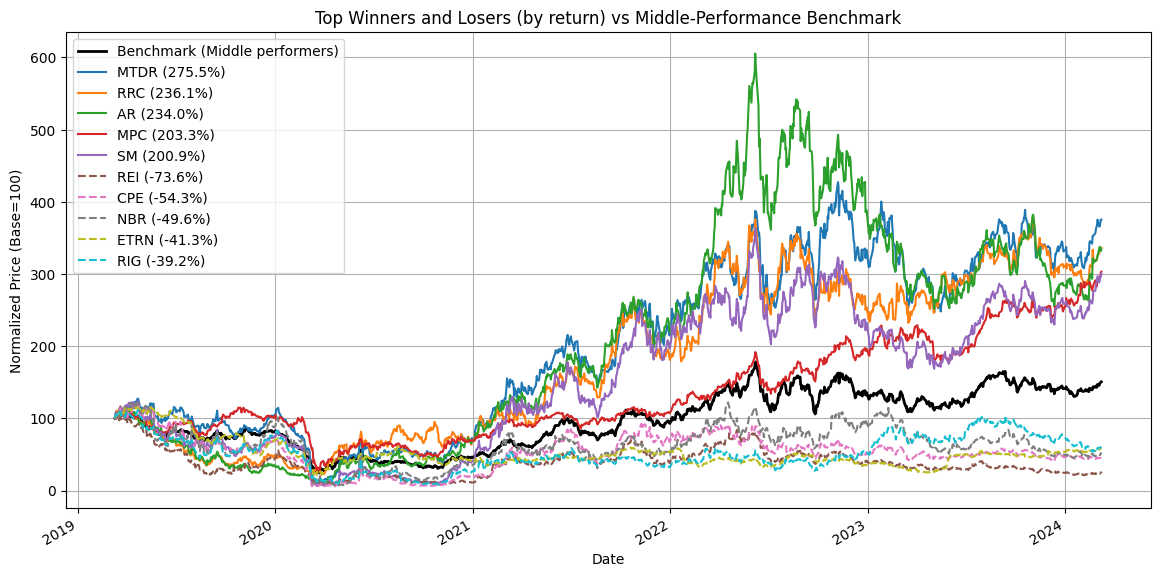

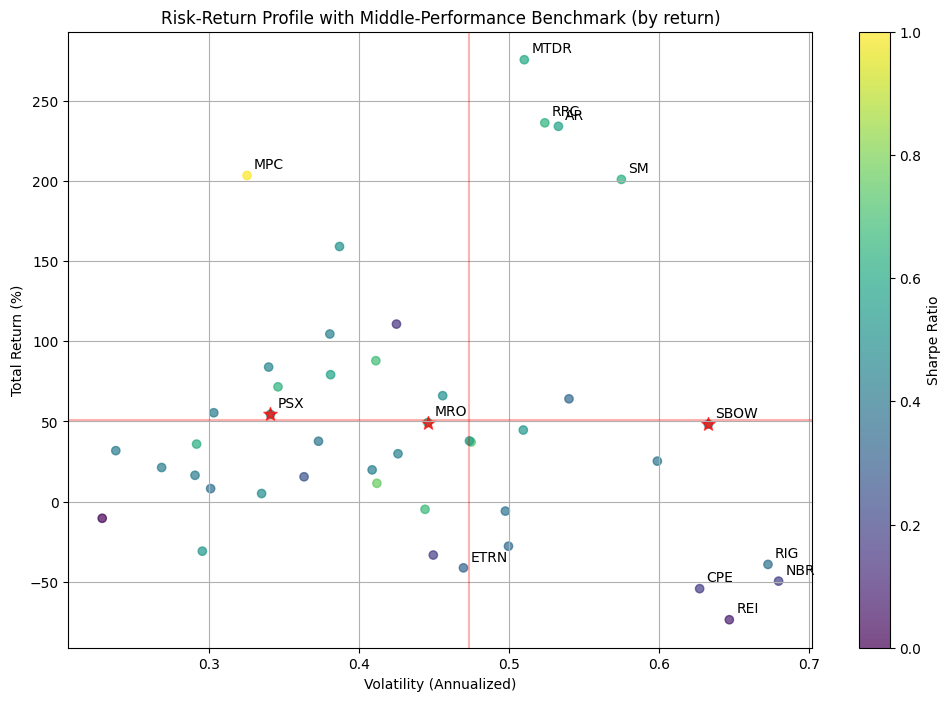

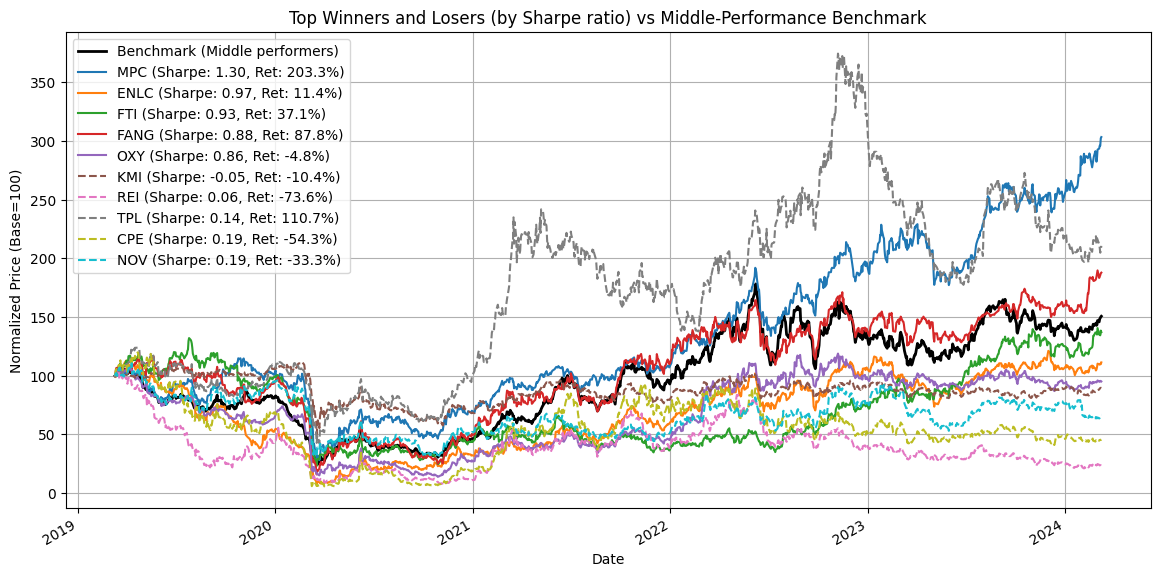

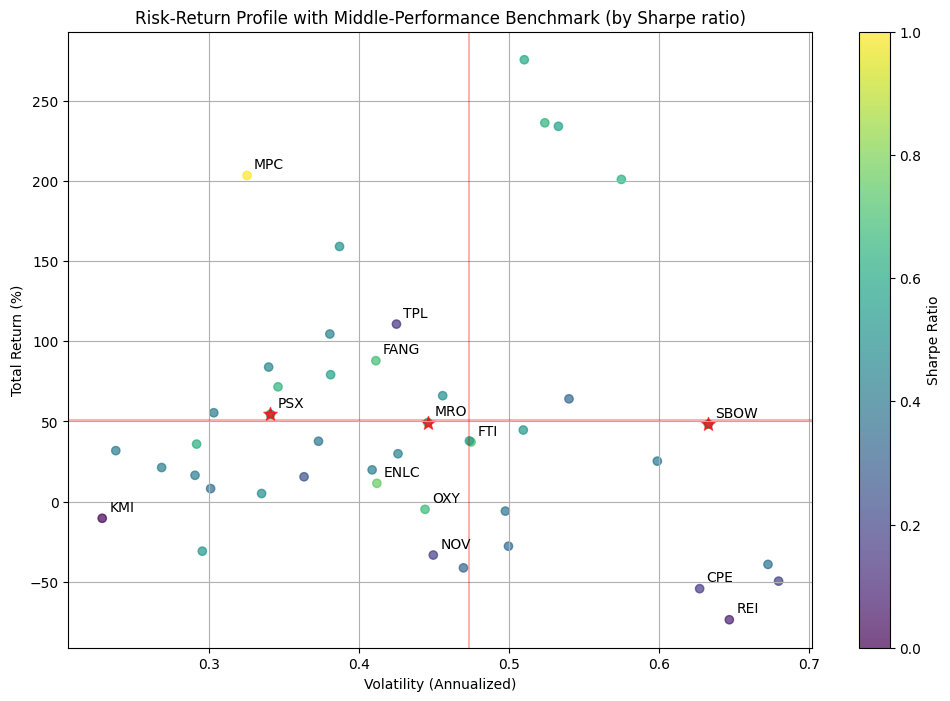

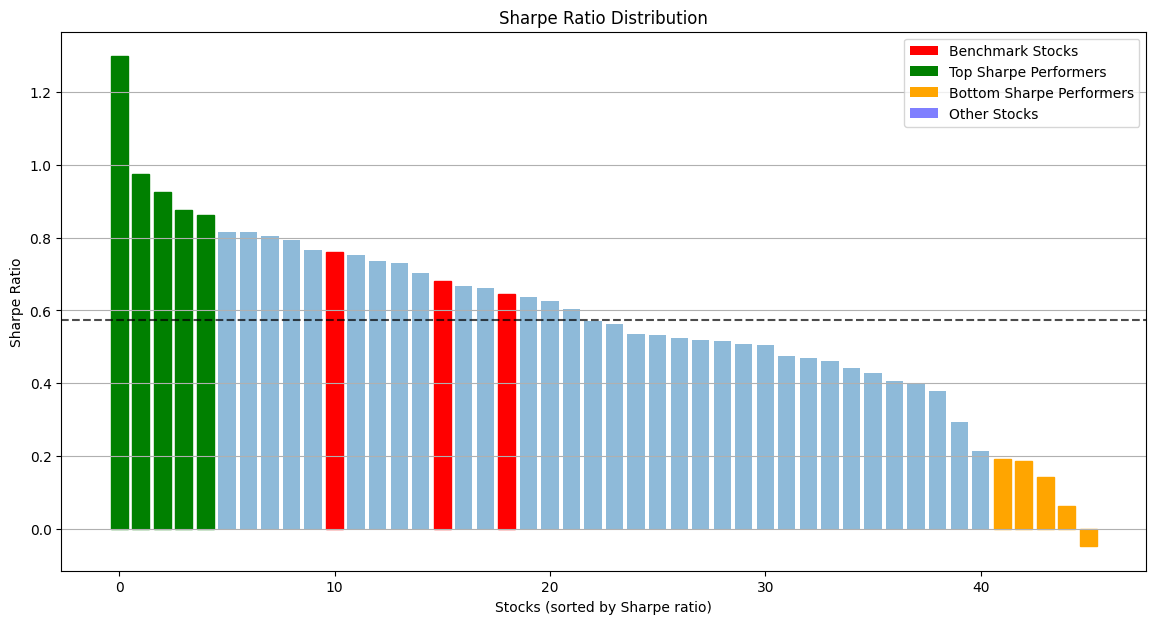

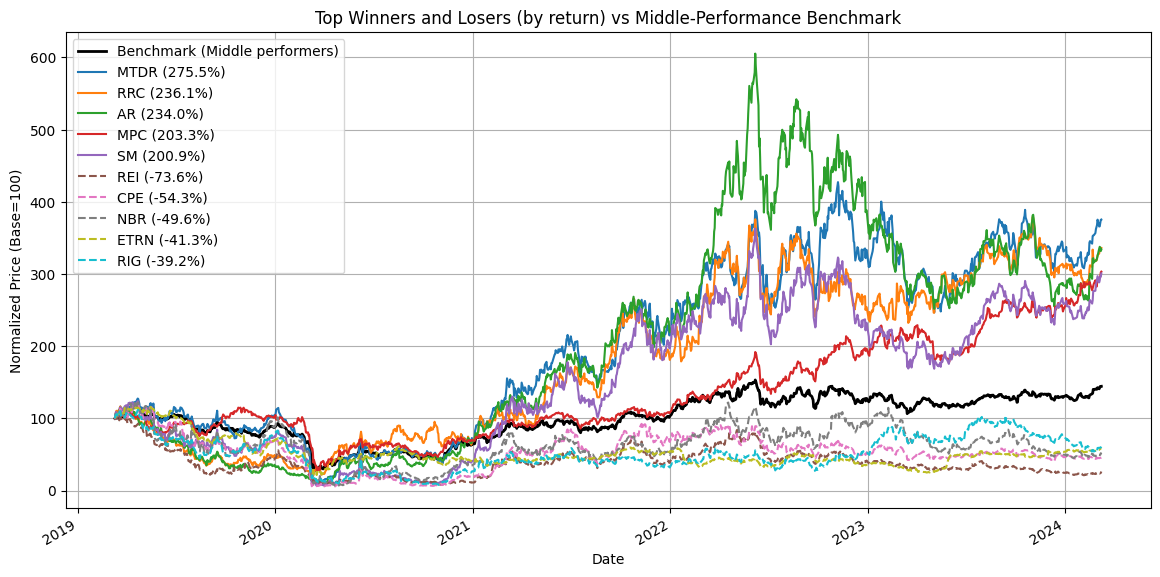

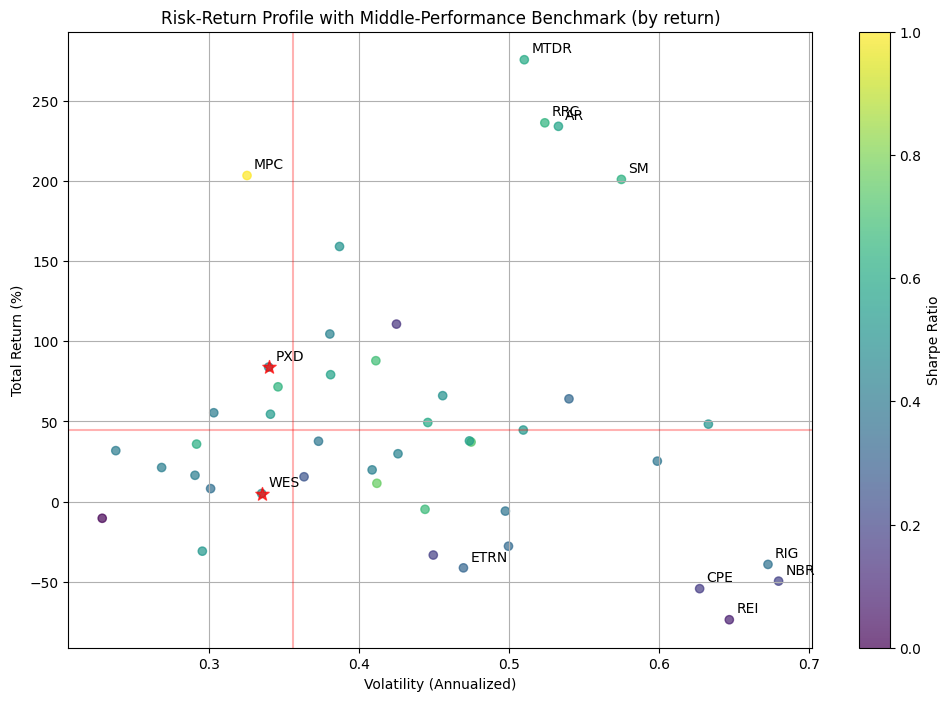

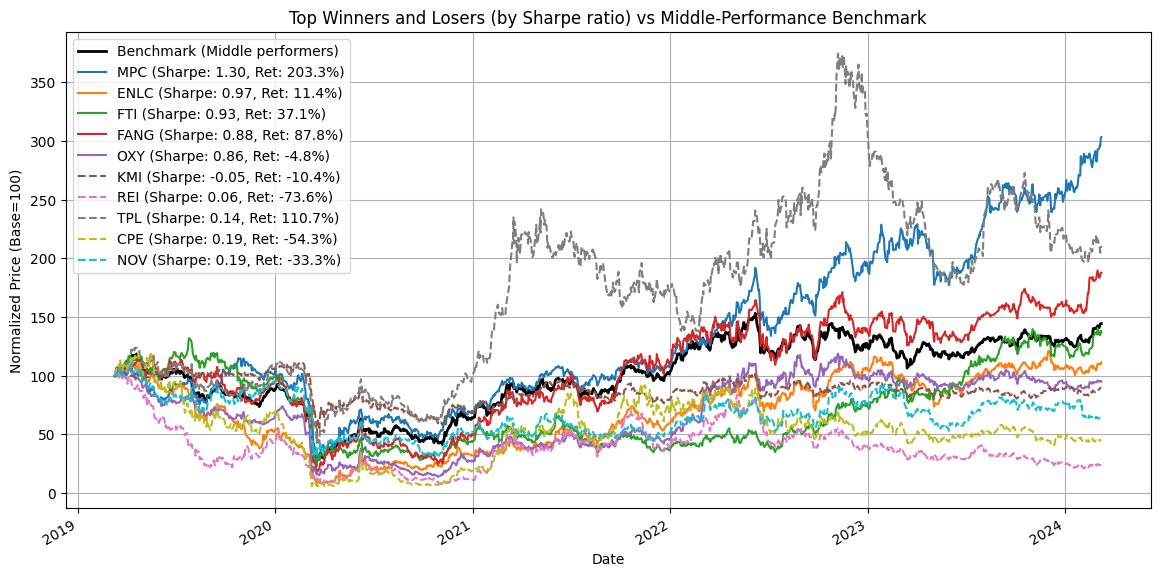

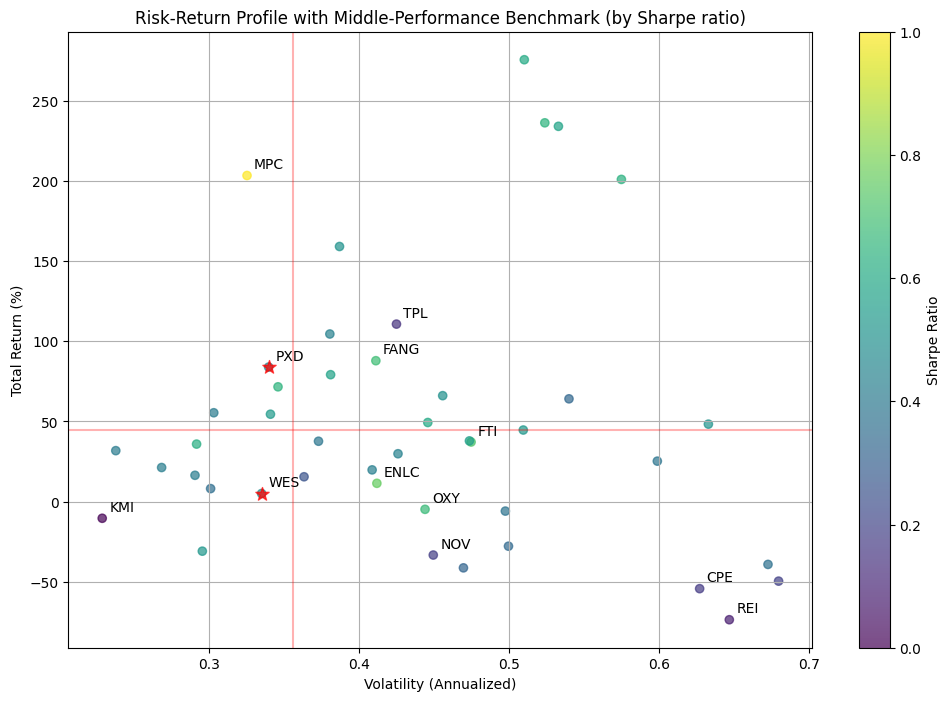

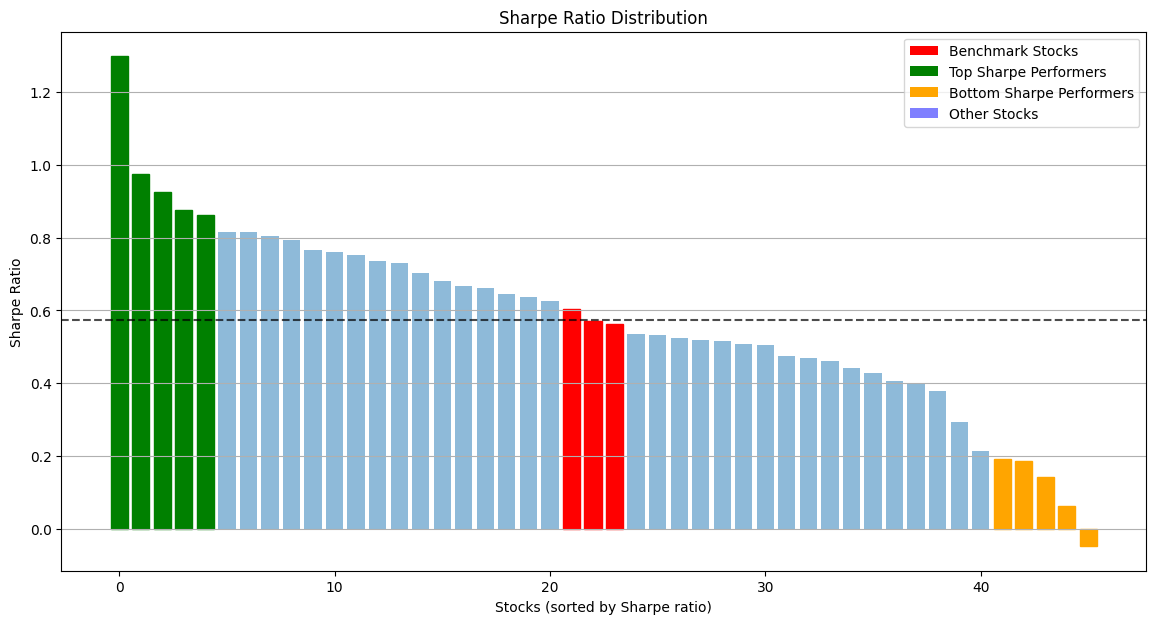

In [11]:
# Find middle performers based on returns
return_benchmarks = find_middle_benchmarks('../../data/clean/energy/clean_energy_close.csv', num_benchmarks=3, by_metric='return')
print("\n" + "="*50 + "\n")

# Find middle performers based on Sharpe ratio
sharpe_benchmarks = find_middle_benchmarks('../../data/clean/energy/clean_energy_close.csv', num_benchmarks=3, by_metric='sharpe')
print("\n" + "="*50 + "\n")

# Analyze winners and losers by return, compared to return-based benchmarks
print("ANALYSIS USING RETURN-BASED BENCHMARKS, FINDING WINNERS/LOSERS BY RETURN:")
return_results = analyze_winners_losers(
    '../../data/clean/energy/clean_energy_close.csv', 
    return_benchmarks['tickers'], 
    top_n=5, 
    by_metric='return'
)
print("\n" + "="*50 + "\n")

# Analyze winners and losers by Sharpe, compared to return-based benchmarks
print("ANALYSIS USING RETURN-BASED BENCHMARKS, FINDING WINNERS/LOSERS BY SHARPE:")
return_sharpe_results = analyze_winners_losers(
    '../../data/clean/energy/clean_energy_close.csv', 
    return_benchmarks['tickers'], 
    top_n=5, 
    by_metric='sharpe'
)
print("\n" + "="*50 + "\n")

# Analyze winners and losers by return, compared to Sharpe-based benchmarks
print("ANALYSIS USING SHARPE-BASED BENCHMARKS, FINDING WINNERS/LOSERS BY RETURN:")
sharpe_return_results = analyze_winners_losers(
    '../../data/clean/energy/clean_energy_close.csv', 
    sharpe_benchmarks['tickers'], 
    top_n=5, 
    by_metric='return'
)
print("\n" + "="*50 + "\n")

# Analyze winners and losers by Sharpe, compared to Sharpe-based benchmarks
print("ANALYSIS USING SHARPE-BASED BENCHMARKS, FINDING WINNERS/LOSERS BY SHARPE:")
sharpe_results = analyze_winners_losers(
    '../../data/clean/energy/clean_energy_close.csv', 
    sharpe_benchmarks['tickers'], 
    top_n=5, 
    by_metric='sharpe'
)